In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

from sklearn import datasets
from sklearn.preprocessing import MinMaxScaler,StandardScaler

import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from utils.helper import fn_plot_torch_hist, fn_plot_confusion_matrix

In [2]:

outDir = os.path.join('output')
RANDOM_STATE = 24
np.random.seed(RANDOM_STATE) # Set Random Seed for reproducible  results
rng = np.random.default_rng(seed = RANDOM_STATE)


EPOCHS =3001 # nos of epochs
ALPHA = 0.001 # learning 
TEST_SIZE = 0.2

# parameters for Matplotlib
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 8),
          'axes.labelsize': 'x-large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large',
         }
CMAP = 'coolwarm'
plt.rcParams.update(params);
plt.set_cmap(CMAP);
plt.style.use('seaborn-v0_8-darkgrid') # plt.style.use('ggplot')

plt .rcParams.update(params)

<Figure size 1500x800 with 0 Axes>

### Prevent Tensorflow from hogging the memory

In [3]:
# physical_devices = tf.config.list_physical_devices('GPU') # tellme nos of GPUs
# if len (physical_devices) > 0:
#  tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [4]:
# physical_devices

In [5]:
data_df = pd.read_csv('fifa_2019.csv')
data_df.shape

(18207, 89)

In [6]:
data_df.head()

,Unnamed: 0,ID,Name,Age,Photo,Nationality,Flag,Overall,Potential,Club,...,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause
0,0,158023,L. Messi,31,https://cdn.sofifa.org/players/4/19/158023.png,Argentina,https://cdn.sofifa.org/flags/52.png,94,94,FC Barcelona,...,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0,€226.5M
1,1,20801,Cristiano Ronaldo,33,https://cdn.sofifa.org/players/4/19/20801.png,Portugal,https://cdn.sofifa.org/flags/38.png,94,94,Juventus,...,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0,€127.1M
2,2,190871,Neymar Jr,26,https://cdn.sofifa.org/players/4/19/190871.png,Brazil,https://cdn.sofifa.org/flags/54.png,92,93,Paris Saint-Germain,...,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0,€228.1M
3,3,193080,De Gea,27,https://cdn.sofifa.org/players/4/19/193080.png,Spain,https://cdn.sofifa.org/flags/45.png,91,93,Manchester United,...,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0,€138.6M
4,4,192985,K. De Bruyne,27,https://cdn.sofifa.org/players/4/19/192985.png,Belgium,https://cdn.sofifa.org/flags/7.png,91,92,Manchester City,...,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0,€196.4M


In [7]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18207 entries, 0 to 18206
Data columns (total 89 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Unnamed: 0                18207 non-null  int64  
 1   ID                        18207 non-null  int64  
 2   Name                      18207 non-null  object 
 3   Age                       18207 non-null  int64  
 4   Photo                     18207 non-null  object 
 5   Nationality               18207 non-null  object 
 6   Flag                      18207 non-null  object 
 7   Overall                   18207 non-null  int64  
 8   Potential                 18207 non-null  int64  
 9   Club                      17966 non-null  object 
 10  Club Logo                 18207 non-null  object 
 11  Value                     18207 non-null  object 
 12  Wage                      18207 non-null  object 
 13  Special                   18207 non-null  int64  
 14  Prefer

In [8]:
data_df.isnull().sum()

Unnamed: 0           0
ID                   0
Name                 0
Age                  0
Photo                0
                  ... 
GKHandling          48
GKKicking           48
GKPositioning       48
GKReflexes          48
Release Clause    1564
Length: 89, dtype: int64

In [9]:
cols = data_df.columns

for col in cols:
    print(f'\nColumns Name: {col} : {data_df[col].unique()}')



Columns Name: Unnamed: 0 : [    0     1     2 ... 18204 18205 18206]

Columns Name: ID : [158023  20801 190871 ... 241638 246268 246269]

Columns Name: Name : ['L. Messi' 'Cristiano Ronaldo' 'Neymar Jr' ... 'B. Worman'
 'D. Walker-Rice' 'G. Nugent']

Columns Name: Age : [31 33 26 27 32 25 29 28 24 30 19 40 22 23 34 35 36 37 21 18 20 39 41 17
 38 45 42 16 44]

Columns Name: Photo : ['https://cdn.sofifa.org/players/4/19/158023.png'
 'https://cdn.sofifa.org/players/4/19/20801.png'
 'https://cdn.sofifa.org/players/4/19/190871.png' ...
 'https://cdn.sofifa.org/players/4/19/241638.png'
 'https://cdn.sofifa.org/players/4/19/246268.png'
 'https://cdn.sofifa.org/players/4/19/246269.png']

Columns Name: Nationality : ['Argentina' 'Portugal' 'Brazil' 'Spain' 'Belgium' 'Croatia' 'Uruguay'
 'Slovenia' 'Poland' 'Germany' 'France' 'England' 'Italy' 'Egypt'
 'Colombia' 'Denmark' 'Gabon' 'Wales' 'Senegal' 'Costa Rica' 'Slovakia'
 'Netherlands' 'Bosnia Herzegovina' 'Morocco' 'Serbia' 'Algeria' 'Austria

In [10]:
data_df = data_df[data_df['Position'].notnull()]
data_df.head()

,Unnamed: 0,ID,Name,Age,Photo,Nationality,Flag,Overall,Potential,Club,...,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause
0,0,158023,L. Messi,31,https://cdn.sofifa.org/players/4/19/158023.png,Argentina,https://cdn.sofifa.org/flags/52.png,94,94,FC Barcelona,...,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0,€226.5M
1,1,20801,Cristiano Ronaldo,33,https://cdn.sofifa.org/players/4/19/20801.png,Portugal,https://cdn.sofifa.org/flags/38.png,94,94,Juventus,...,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0,€127.1M
2,2,190871,Neymar Jr,26,https://cdn.sofifa.org/players/4/19/190871.png,Brazil,https://cdn.sofifa.org/flags/54.png,92,93,Paris Saint-Germain,...,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0,€228.1M
3,3,193080,De Gea,27,https://cdn.sofifa.org/players/4/19/193080.png,Spain,https://cdn.sofifa.org/flags/45.png,91,93,Manchester United,...,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0,€138.6M
4,4,192985,K. De Bruyne,27,https://cdn.sofifa.org/players/4/19/192985.png,Belgium,https://cdn.sofifa.org/flags/7.png,91,92,Manchester City,...,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0,€196.4M


In [11]:
data_df.isnull().sum()

Unnamed: 0           0
ID                   0
Name                 0
Age                  0
Photo                0
                  ... 
GKHandling           0
GKKicking            0
GKPositioning        0
GKReflexes           0
Release Clause    1504
Length: 89, dtype: int64

In [12]:
# Following columns appear to be relevant for our analysis
rel_cols = ['Position', 'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling',
            'Curve', 'FKAccuracy', 'LongPassing', 'BallControl', 'Acceleration',
            'SprintSpeed', 'Agility', 'Reactions', 'Balance', 'ShotPower',
            'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression',
            'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure',
            'Marking', 'StandingTackle', 'SlidingTackle', 'GKDiving', 'GKHandling',
            'GKKicking', 'GKPositioning', 'GKReflexes']

In [13]:
# keeping relevant columns
data_df = data_df[rel_cols]
data_df.head()

,Position,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,...,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes
0,RF,95.0,70.0,90.0,86.0,97.0,93.0,94.0,87.0,96.0,...,75.0,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0
1,ST,94.0,89.0,81.0,87.0,88.0,81.0,76.0,77.0,94.0,...,85.0,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0
2,LW,87.0,62.0,84.0,84.0,96.0,88.0,87.0,78.0,95.0,...,81.0,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0
3,GK,13.0,21.0,50.0,13.0,18.0,21.0,19.0,51.0,42.0,...,40.0,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0
4,RCM,82.0,55.0,92.0,82.0,86.0,85.0,83.0,91.0,91.0,...,79.0,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0


In [14]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18147 entries, 0 to 18206
Data columns (total 34 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Position         18147 non-null  object 
 1   Finishing        18147 non-null  float64
 2   HeadingAccuracy  18147 non-null  float64
 3   ShortPassing     18147 non-null  float64
 4   Volleys          18147 non-null  float64
 5   Dribbling        18147 non-null  float64
 6   Curve            18147 non-null  float64
 7   FKAccuracy       18147 non-null  float64
 8   LongPassing      18147 non-null  float64
 9   BallControl      18147 non-null  float64
 10  Acceleration     18147 non-null  float64
 11  SprintSpeed      18147 non-null  float64
 12  Agility          18147 non-null  float64
 13  Reactions        18147 non-null  float64
 14  Balance          18147 non-null  float64
 15  ShotPower        18147 non-null  float64
 16  Jumping          18147 non-null  float64
 17  Stamina          

In [15]:
data_df['Position'].unique()

array(['RF', 'ST', 'LW', 'GK', 'RCM', 'LF', 'RS', 'RCB', 'LCM', 'CB',
       'LDM', 'CAM', 'CDM', 'LS', 'LCB', 'RM', 'LAM', 'LM', 'LB', 'RDM',
       'RW', 'CM', 'RB', 'RAM', 'CF', 'RWB', 'LWB'], dtype=object)

In [16]:
goalkeeper = 'GK'
forward = ['RF', 'ST', 'LW', 'LF', 'RS', 'CF', 'LS', 'RW']
midfielder = ['CM','RCM','LCM','CDM','RDM','LDM', 'CAM', 'LAM','RAM','RM','LM']
defender = ['CB','LCB','RCB','RWB', 'LWB','RB', 'LB']

In [17]:
len(data_df['Position'].unique()) - len(forward) - len(midfielder) - len(defender)

1

In [18]:
# Assign labels to goalkeepers
data_df.loc[data_df['Position'] == 'GK','Position'] = 0

# Defenders
data_df.loc[data_df['Position'].isin(defender),'Position'] = 1

#Midfielders
data_df.loc[data_df['Position'].isin(midfielder),'Position'] = 2

#Forwards
data_df.loc[data_df['Position'].isin(forward),'Position'] = 3

# Assist Pandas in data conversion

data_df['Position'] = pd.to_numeric(data_df['Position'], downcast = 'integer')

In [19]:
labels_dic = {0: 'Goalkeepers',1:'Defender', 2: 'Midfielder', 3: 'Forward'}

In [20]:
features_df = data_df.drop('Position', axis = 1)
labels = data_df.Position

In [21]:
labels = pd.get_dummies(labels)

In [22]:
X_train,X_test,y_train,y_test = train_test_split(features_df,labels,
                                                test_size = TEST_SIZE,
                                                stratify = labels,
                                                random_state = RANDOM_STATE)
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((14517, 33), (3630, 33), (14517, 4), (3630, 4))

In [23]:
sc = StandardScaler()

X_train = sc.fit_transform(X_train)

X_test = sc.transform(X_test)


In [24]:
torch.version.cuda

'12.1'

In [25]:
torch.cuda.current_device()

0

In [26]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [27]:
torch.cuda.get_device_name(torch.cuda.current_device())

'NVIDIA GeForce RTX 2060 SUPER'

In [28]:
input_dim = X_train.shape[1] # number of cols in features

model = nn.Sequential(nn.Linear(input_dim,18),
                      nn.ReLU(),
                      nn.Linear(18,4)
                     )
model = model.to(device)

In [29]:
print(model)

Sequential(
  (0): Linear(in_features=33, out_features=18, bias=True)
  (1): ReLU()
  (2): Linear(in_features=18, out_features=4, bias=True)
)


In [30]:
list(model.parameters())

[Parameter containing:
 tensor([[ 0.1520,  0.1718,  0.0198, -0.0475, -0.1538,  0.0646, -0.0839, -0.1174,
           0.0672, -0.0191,  0.1369, -0.1412, -0.0471, -0.0168,  0.1221, -0.0795,
          -0.0546, -0.0990,  0.0742, -0.0144,  0.1529, -0.1195,  0.0084,  0.1644,
          -0.0647,  0.1674,  0.0273, -0.0869,  0.0859,  0.1346, -0.0398, -0.1666,
           0.0727],
         [ 0.0738,  0.1592,  0.1542, -0.1707, -0.1663, -0.1064,  0.0073, -0.0388,
           0.0336,  0.0070,  0.0908, -0.0884, -0.0783,  0.0395,  0.1473, -0.1215,
           0.1617,  0.1540,  0.0906,  0.0990,  0.0377,  0.1523, -0.0749, -0.0695,
          -0.1017, -0.0530,  0.0733,  0.1680,  0.1200,  0.1071, -0.0325, -0.0791,
          -0.0135],
         [-0.1344,  0.1344,  0.0785, -0.0177, -0.1052,  0.1330, -0.0618, -0.0693,
          -0.0715,  0.0642, -0.1643,  0.0339,  0.0442, -0.1324,  0.0779, -0.1599,
           0.1284, -0.0267, -0.0583,  0.0864,  0.0578,  0.0397,  0.0173,  0.0538,
           0.0788, -0.1527,  0.0482

In [31]:
print(f'Number of parameter: {len(list(model.parameters()))}')

Number of parameter: 4


In [32]:
print(f'Layer 1 Weights: {list(model.parameters())[0].shape}')
print(f'Layer 1 bias   : {list(model.parameters())[1].shape}')
print(f'Layer 2 Weights: {list(model.parameters())[2].shape}')
print(f'Layer 2 bias   : {list(model.parameters())[3].shape}')

Layer 1 Weights: torch.Size([18, 33])
Layer 1 bias   : torch.Size([18])
Layer 2 Weights: torch.Size([4, 18])
Layer 2 bias   : torch.Size([4])


In [33]:
train_X = Variable(torch.Tensor(X_train)).to(device)
test_X = Variable(torch.Tensor(X_test)).to(device)
train_y = Variable(torch.Tensor(y_train.to_numpy())).to(device)
test_y = Variable(torch.Tensor(y_test.to_numpy())).to(device)

In [1]:
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr = ALPHA)

loss, tloss, n_epoch, acc, tacc= [],[],[],[],[]

for epoch in range(EPOCHS):
    model.train() # set ur model in train mode
    
    predict = model(train_X) # make prediction

    curr_loss = loss_fn(predict,train_y) # calculate loss
    
   ########################## 
   ### Back Propagation #####
   ##########################
    optimizer.zero_grad()
    curr_loss.backward()
    optimizer.step()
    
    loss.append(curr_loss.data.item())
    
    _, y_pred = torch.max(predict, 1)
    
    curr_acc = accuracy_score(y_train.to_numpy().argmax(axis=1),y_pred.data.cpu())
    
    acc.append(curr_acc)
    
    model.eval() # dont update weights
    
    predict_tst = model(test_X) # MAKE PREDICTION
    
    curr_loss_tst = loss_fn(predict_tst, test_y)  # Calculate loss
    
    tloss.append(curr_loss_tst.data.item())
    
    _, y_pred = torch.max(predict, 1)
    
    curr_acc_tst = accuracy_score(y_train.to_numpy().argmax(axis=1),y_pred.data.cpu())

    tacc.append(curr_acc_tst)
    
    n_epoch.append(epoch)

NameError: name 'nn' is not defined

In [35]:
loss_df = pd.DataFrame({'epoch': n_epoch,
                       'loss': loss,
                       'test loss' : tloss,
                       'acc':acc,
                       'test acc': tacc
                       })
loss_df.head()

,epoch,loss,test loss,acc,test acc
0,0,1.468605,1.456553,0.249225,0.249225
1,1,1.457445,1.445379,0.253840,0.253840
2,2,1.446319,1.434228,0.258111,0.258111
3,3,1.435218,1.423122,0.262451,0.262451
4,4,1.424161,1.412052,0.267411,0.267411


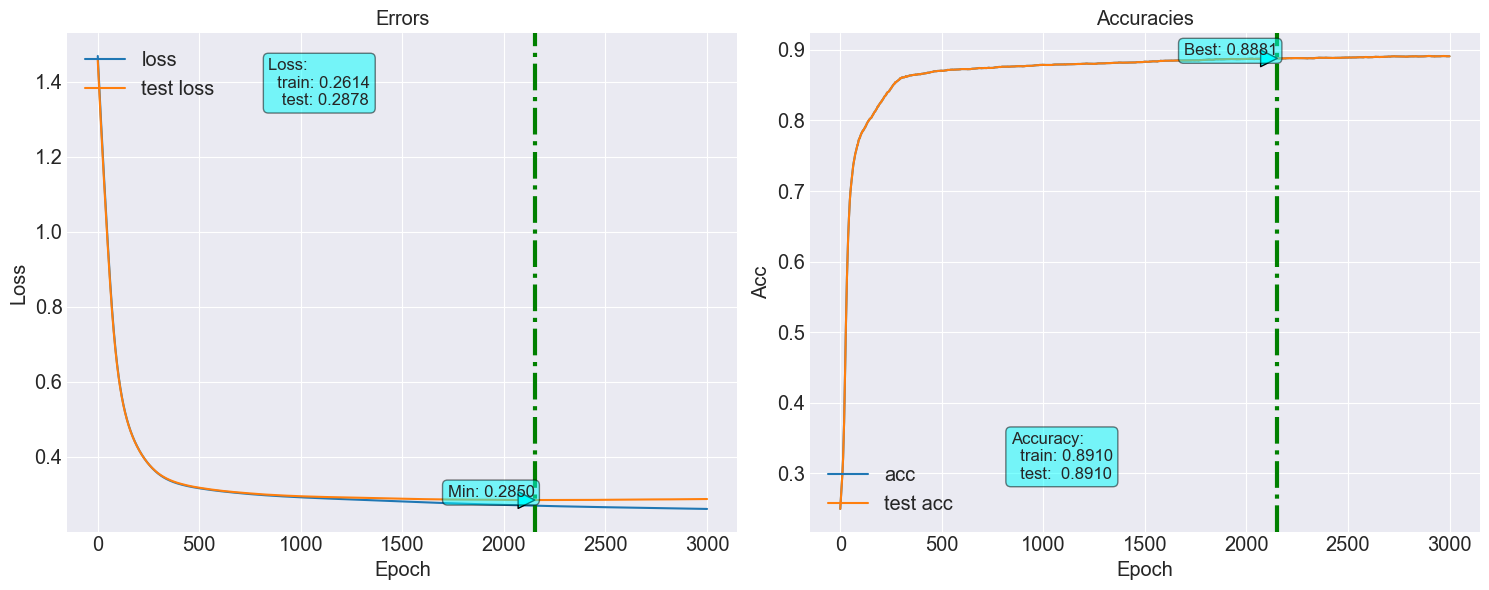

In [36]:
fn_plot_torch_hist(loss_df)

In [37]:
predict = model(train_X)

_, y_pred = torch.max(predict, 1)

accuracy_score(y_train.to_numpy().argmax(axis=1),y_pred.data.cpu())


0.8910243163187986

In [38]:
predict = model(test_X)

_, y_pred = torch.max(predict, 1)

accuracy_score(y_test.to_numpy().argmax(axis=1),y_pred.data.cpu())

0.8848484848484849